In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

import pandas as pd

lambda = střední uražená dráha
# $p(x|meas, \lambda) = \frac{p(meas|x)\cdot p(x|\lambda)}{p(meas|\lambda)}$, vidím jen částice, které mohu změřit

In [6]:
df_1 = pd.read_csv("castice_1.csv").drop("Unnamed: 0", axis = 1) #10, 60
df_2 = pd.read_csv("castice_2.csv").drop("Unnamed: 0", axis = 1) #10, 300
df_3 = pd.read_csv("castice_3.csv").drop("Unnamed: 0", axis = 1) #17, 60
df_4 = pd.read_csv("castice_4.csv").drop("Unnamed: 0", axis = 1) #25, 300
df_5 = pd.read_csv("castice_5.csv").drop("Unnamed: 0", axis = 1) #0.5, 300

In [7]:
df_1.head()

,x
0,13.263517
1,1.280858
2,6.630016
3,9.396254
4,8.016764


In [8]:
#první soubor, nedělal jsem custom likelihood, je to pod tím analyticky

In [21]:
from pymc3 import Continuous
import theano.tensor as tt

class Castice(Continuous):

    def __init__(self, lam, *args, **kwargs):
        super(Castice, self).__init__(*args, **kwargs)

        self.lam = lam

    def logp(self, x):
        obs = np.log(-np.exp(-20/self.lam) + np.exp(-1/self.lam))
        return np.log(1/self.lam) - x/self.lam - obs

In [22]:
with pm.Model() as model_1:
    lam = pm.HalfNormal("lam", 15)
    likelihood = Castice("likelihood", lam = lam, observed = df_1["x"].values)

In [29]:
with model_1:
    trace_1 = pm.sample(cores =1)

/Users/hynekjakes/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


/Users/hynekjakes/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'lam'}>,
        <AxesSubplot:title={'center':'lam'}>]], dtype=object)

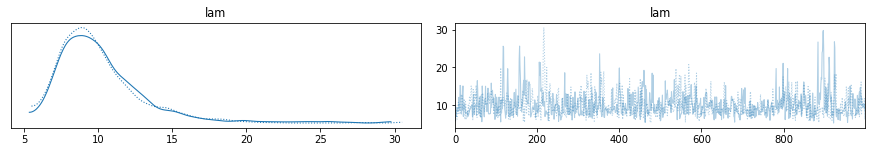

In [30]:
az.plot_trace(trace_1)

In [31]:
az.summary(trace_1)

/Users/hynekjakes/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lam,10.113,3.014,5.728,15.324,0.136,0.097,573.0,645.0,1.0


/Users/hynekjakes/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

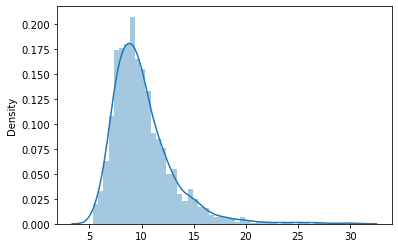

In [32]:
sns.distplot(trace_1["lam"])

$p(x|meas, \lambda) = \frac{p(meas|x)\cdot p(x|\lambda)}{p(meas|\lambda)}$, vidím jen částice, které mohu změřit

In [24]:
def f(x, obs): # = p(meas|x)
    return ((x>1) & (x < 20)).astype("int")

In [25]:
lam = np.linspace(0, 30, 1000).reshape(-1, 1)

In [26]:
def log_likelihood(data, lam):
    obs = np.log(-np.exp(-20/lam) + np.exp(-1/lam))
    return np.sum(np.log(1/lam) - data/lam - obs, axis = 1)

In [27]:
def log_prior(lam):
    return np.zeros(shape = lam.shape)

In [33]:
log_post = log_likelihood(df_1["x"].values, lam) + log_prior(lam)[:, 0]
log_post[0:4] = -1e7

<ipython-input-26-ae10dd8e25d9>:2: RuntimeWarning: divide by zero encountered in true_divide
  obs = np.log(-np.exp(-20/lam) + np.exp(-1/lam))
<ipython-input-26-ae10dd8e25d9>:2: RuntimeWarning: divide by zero encountered in log
  obs = np.log(-np.exp(-20/lam) + np.exp(-1/lam))
<ipython-input-26-ae10dd8e25d9>:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(np.log(1/lam) - data/lam - obs, axis = 1)
<ipython-input-26-ae10dd8e25d9>:3: RuntimeWarning: invalid value encountered in subtract
  return np.sum(np.log(1/lam) - data/lam - obs, axis = 1)


In [34]:
post = np.exp(log_post)/np.exp(log_post).mean()

Text(0, 0.5, 'posterior_density')

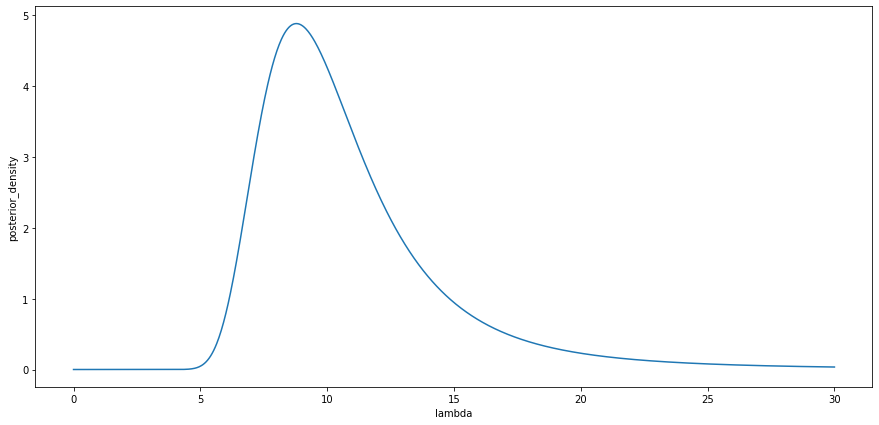

In [35]:
fig = plt.figure(figsize = [15, 7])
plt.plot(lam, post)
plt.xlabel("lambda")
plt.ylabel("posterior_density")

In [38]:
(lam.flatten()*post).mean()

0.5571811840781513